In [1]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

df = pd.read_csv('/local/work/merengelke/aipal/poland/aipal/predict.csv')

In [2]:
def prediction_data_pruner(df, threshold=0):
    """Remove data rows based on the threshold of missing values."""
    data = df
    mandatory_columns = ['Fibrinogen_g_L', 'LDH_UI_L', 'WBC_G_L', 'Lymphocytes_G_L',
    'MCHC_g_L', 'MCV_fL', 'Monocytes_G_L', 'Platelets_G_L',
    'PT_percent']
    
    ['MCV_fL', 'PT_percent', 'LDH_UI_L', 'MCHC_g_L', 'WBC_G_L', 'Fibrinogen_g_L', 'Monocytes_G_L', 'Platelets_G_L', 'Lymphocytes_G_L']

    data["nan_percentage"] = data[mandatory_columns].isna().mean(axis=1)

    # Prune data where the percentage of NaN values is above the threshold
    data = data[data["nan_percentage"] <= threshold]
    data.drop(columns=["nan_percentage"], inplace=True)
    return data


/tmp/ipykernel_4152928/3935863735.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=["nan_percentage"], inplace=True)


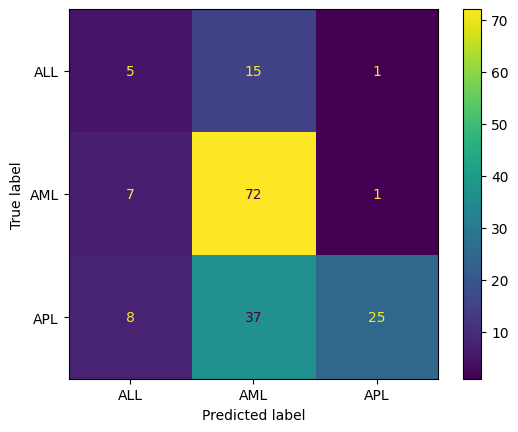

In [3]:
def get_confusion_matrix(df):
    adult_df = df[df['age'] >= 18].copy()
    adult_df[["prediction.ALL", "prediction.AML", "prediction.APL"]] = adult_df[["prediction.ALL", "prediction.AML", "prediction.APL"]].astype(float)

    adult_df = prediction_data_pruner(adult_df, threshold=0.2)

    adult_df["max_pred"] = adult_df[["prediction.ALL", "prediction.AML", "prediction.APL"]].idxmax(axis=1)
    adult_df["max_pred"] = adult_df["max_pred"].str.split(".").str[1]
    return ConfusionMatrixDisplay.from_predictions(adult_df["class"], adult_df["max_pred"])

get_confusion_matrix(df)

In [4]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import numpy as np

# Binarize the class labels
classes = adult_df['max_pred'].unique()
y = label_binarize(adult_df['class'], classes=classes)
n_classes = y.shape[1]

# Ensure the predictions are in the correct order
y_score = adult_df[["prediction.ALL", "prediction.AML", "prediction.APL"]].values

# Calculate the AUC for each class
auc_scores = []
for i in range(n_classes):
    # Calculate AUC using true binary labels vs. prediction scores for class i
    auc_score = roc_auc_score(y[:, i], y_score[:, i])
    auc_scores.append(auc_score)
    print(f"AUC for {classes[i]}: {auc_score}")

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f"Average AUC: {average_auc}")

AUC for AML: 0.34478021978021983
AUC for ALL: 0.3879365079365079
AUC for APL: 0.9265912305516266
Average AUC: 0.5531026527561181


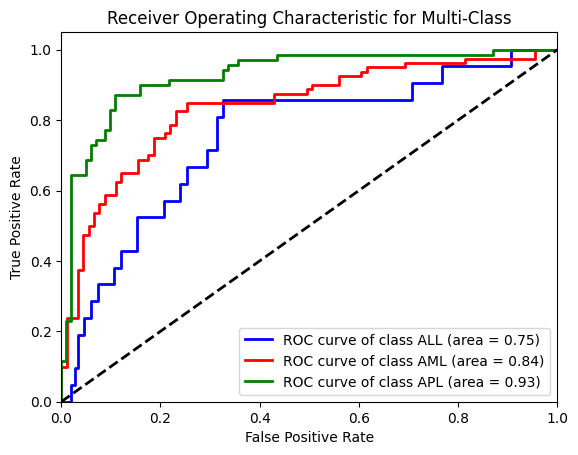

In [5]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming adult_df is your DataFrame and it has been processed as per your selection

# Binarize the class labels
# classes = adult_df['max_pred'].unique()
classes = ["ALL", "AML", "APL"]
y = label_binarize(adult_df['class'], classes=classes)
n_classes = y.shape[1]

# Convert predictions to a similar format for ROC calculation
y_score = adult_df[["prediction.ALL", "prediction.AML", "prediction.APL"]].values

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()